In [18]:
import sys
sys.path.append('../')
import pandas as pd
import backtrader as bt
from datetime import datetime
import matplotlib.pyplot as plt
from Tools.backtest_tools import *
from Tools.plotting import CandlePlot
import pandas_ta as ta
from itertools import product

In [19]:
# Load the data and convert the timestamp to datetime
df = pd.read_csv('../DB/5m/ARBUSDT_5m.csv', parse_dates=True) 

# df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
# # # Convert 'date' to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])  # Assuming the 'date' is in milliseconds

# # # Set 'date' as index
df.set_index('datetime', inplace=True)

# df.iloc[0]
# df.dtypes
# df.head()
df_t = df[:].copy()

In [20]:
class Breakout:
    def __init__(
            self, 
            df, 
            type=['long', 'short'],
           
                ) -> None:
        
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.trades = pd.DataFrame()
        self.dist =0.003
   
    def _find_high_low(self, candle, df, window=5):
    
        PIVOT_H = 1
        PIVOT_L = -1
        
        if ((candle-window) <0) | ((candle+window)>=len(df)):
            return 0
        
        pivot_high = True
        pivot_low = True
        
        for i in range(candle - window, candle + window + 1):
            if df.iloc[candle].high < df.iloc[i].high:
                pivot_high = False
            if df.iloc[candle].low > df.iloc[i].low:
                pivot_low = False
        
        if pivot_high and pivot_low:
            return 0
        elif pivot_high:
            return PIVOT_H
        elif pivot_low:
            return PIVOT_L
        else:
            return 0 
    

        

    def populate_indicators(self):
        # -- Clear dataset --
        df = self.df
        # df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

        df = df.reset_index()
        
        df['hh_ll'] = df.apply(lambda row: self._find_high_low(row.name, df), axis=1)
        df.set_index('datetime', inplace=True)

        self.df = df 
        return self.df
    
    def generate_signals(self):
        df = self.df

        df['buy_condition'] = False
        df['sell_condition'] = False
        df['close_buy_condition'] = False
        df['close_sell_condition'] = False

        last_h_l = {"hh": None, "ll": None}

        for index, row in df.iterrows():
            # Update the last higher-high (HH) and lower-low (LL) if there's a pivot high or low
            if row['hh_ll'] == 1:  # New pivot high
                last_h_l['hh'] = row['high']
            elif row['hh_ll'] == -1:  # New pivot low
                last_h_l['ll'] = row['low']

            # Store the last HH and LL in the data frame
            df.loc[index, 'hh'] = last_h_l['hh']
            df.loc[index, 'll'] = last_h_l['ll']

        self.df = df    
        return self.df



    def populate_buy_sell(self): 
        df = self.df
        # -- Initiate populate --
        BUY = 1
        SELL = -1
        NONE = 0
        dist = self.dist
        
        df['SIGNAL'] = NONE
        current_position = 0 

        for index, row in df.iterrows():
            if (current_position !=BUY) and (row['hh'] is not None) and (row['close'] >= row['hh']- row['hh']*dist ): #
                df.loc[index, 'SIGNAL'] = BUY
                current_position = BUY
            elif (current_position !=SELL) and (row['ll'] is not None) and (row['close'] <= row['ll']+ row['ll']*dist) : #+ row['close']*dist
                df.loc[index, 'SIGNAL'] = SELL
                current_position = SELL


        if self.use_long:
            # -- Populate open long market --
            df.loc[
                df['SIGNAL'] == BUY,
                "open_long_market"
            ] = True
            
            # -- Populate close long market --
            # df.loc[
            #     df['close_buy_condition'] == True
            #     , f"close_long_market"
            # ] = True

        if self.use_short:
            # -- Populate open short market --
            df.loc[
                df['SIGNAL'] == SELL,
                "open_short_market"
            ] = True
            
            # -- Populate close short market --
            # df.loc[
            #     df['close_sell_condition'] == True 
            #     , "close_short_market"
            # ] = True
               
        self.df = df   
        return self.df

    # Running the backtest
    
    def run_backtest(self, initial_wallet=1000, leverage=1,  sl_pct=0.01, tp_pct=0.06, trailing_sl_trigger_pct=0.003, trailing_sl_pct=0.001):
        df = self.df
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position_long = None
        current_position_short = None
        sl_pct = sl_pct
        tp_pct = tp_pct
        trailing_sl_trigger_pct = trailing_sl_trigger_pct
        trailing_sl_pct = trailing_sl_pct
        dist = self.dist


        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet

                if current_position_long:
                    close_price = row['close']
                    trade_result = (close_price - current_position_long['price']) / current_position_long['price']
                    temp_wallet += temp_wallet * trade_result
                    fee = temp_wallet * taker_fee
                    temp_wallet -= fee
                    days.append({
                        "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                        "wallet":temp_wallet,
                        "price":row['close']
                    })
                if current_position_short:
                    close_price = row['close']
                    trade_result = (current_position_short['price'] - close_price) / current_position_short['price']
                    temp_wallet += temp_wallet * trade_result
                    fee = temp_wallet * taker_fee
                    temp_wallet -= fee
                    days.append({
                        "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                        "wallet":temp_wallet,
                        "price":row['close']
                    })
                            
                
            previous_day = current_day
            if current_position_long:
                current_position_long = self._trail_stop(current_position_long, row, trailing_sl_trigger_pct=trailing_sl_trigger_pct, trailing_sl_pct=trailing_sl_pct)
                
                # -- Check for closing position --
                                     
                    # -- Close LONG market --
                if row['low'] <= current_position_long['sl']:
                    close_price = row['close']
                    trade_result = ((close_price - current_position_long['price']) / current_position_long['price']) * leverage
                    wallet += wallet * trade_result
                    fee = wallet * taker_fee
                    wallet -= fee
                    trades.append({
                        "open_date": current_position_long['date'],
                        "close_date": index,
                        "position": "LONG",
                        "open_reason": current_position_long['reason'],
                        "close_reason": "SL",
                        "open_price": current_position_long['price'],
                        "close_price": current_position_long['sl'],
                        "open_fee": current_position_long['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_position_long['size'],
                        "close_trade_size": wallet,
                        "wallet": wallet
                    })
                    current_position_long = None
                elif row['high'] >= current_position_long['tp']:
                    close_price = row['close']
                    trade_result = ((close_price - current_position_long['price']) / current_position_long['price']) * leverage
                    wallet += wallet * trade_result
                    fee = wallet * taker_fee
                    wallet -= fee
                    trades.append({
                        "open_date": current_position_long['date'],
                        "close_date": index,
                        "position": "LONG",
                        "open_reason": current_position_long['reason'],
                        "close_reason": "TP",
                        "open_price": current_position_long['price'],
                        "close_price": current_position_long['tp'],
                        "open_fee": current_position_long['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_position_long['size'],
                        "close_trade_size": wallet,
                        "wallet": wallet
                    })
                    current_position_long = None
                        
            if current_position_short:
                current_position_short = self._trail_stop(current_position_short, row, trailing_sl_trigger_pct=trailing_sl_trigger_pct, trailing_sl_pct=trailing_sl_pct)
                # -- Close SHORT Market --
                if row['high'] >= current_position_short['sl']:
                    close_price = row['close']
                    trade_result = ((current_position_short['price'] - close_price) / current_position_short['price']) * leverage
                    wallet += wallet * trade_result
                    fee = wallet * taker_fee
                    wallet -= fee
                    trades.append({
                        "open_date": current_position_short['date'],
                        "close_date": index,
                        "position": "SHORT",
                        "open_reason": current_position_short['reason'],
                        "close_reason": "SL",
                        "open_price": current_position_short['price'],
                        "close_price": current_position_short['sl'],
                        "open_fee": current_position_short['fee'],
                        "close_fee": fee,
                        "open_trade_size": current_position_short['size'],
                        "close_trade_size": wallet,
                        "wallet": wallet
                    })
                    current_position_short = None
                elif row['low'] <= current_position_short['tp']:
                    close_price = row['close']
                    trade_result = ((current_position_short['price'] - close_price) / current_position_short['price']) * leverage
                    wallet += wallet * trade_result
                    fee = wallet * taker_fee
                    wallet -= fee
                    trades.append({
                        "open_date": current_position_short['date'],
                        "close_date": index,
                        "position": "SHORT",
                        "open_reason": current_position_short['reason'],
                        "close_reason": "TP",
                        "open_price": current_position_short['price'],
                        "close_price": current_position_short['tp'],
                        "open_fee": current_position_short['fee'],
                        "close_fee": fee,
                        "open_trade_size": current_position_short['size'],
                        "close_trade_size": wallet,
                        "wallet": wallet
                    })
                    current_position_short = None


            # -- Check for opening position --
            else:
                # -- Open long Market --
                if row['open_long_market']==True:
                    # print('LONG_POSITION_DETECTED')
                    open_price = row['close'] -row['close'] * dist
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet

                    sl = open_price * (1 - sl_pct)  # Stop-loss for BUY
                    tp = open_price * (1 + tp_pct)  # Take-profit for BUY

                    current_position_long = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                        'sl': sl,
                        'tp': tp
                    }
                # -- Open short Market --
                if row['open_short_market']==True:
                    # print('SHORT_POSITION_DETECTED')
                    open_price = row['close'] + row['close'] * dist
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet

                    sl = open_price * (1 + sl_pct)  # Stop-loss for SELL
                    tp = open_price * (1 - tp_pct)  # Take-profit for SELL

                    current_position_short = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT",
                        'sl': sl,
                        'tp': tp
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
            self.trades = df_trades
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }
    
    def _trail_stop(self, current_position, row, trailing_sl_trigger_pct, trailing_sl_pct):
        """
        Adjust the trailing stop loss based on price movement for crypto.
        
        current_position: dict, the current open position details
        row: pandas Series, current row of price data (includes 'high', 'low', 'close')
        trailing_sl_trigger_pct: float, the percentage at which the trailing stop is triggered
        trailing_sl_pct: float, the percentage distance for the trailing stop
        """
        sl = current_position['sl']  # Existing stop loss
        entry_price = current_position['price']  # Entry price of the position

        # Trailing stop for BUY position
        if current_position['side'] == 'LONG':
            bid = row['close']  # Use the close price as bid price for simplicity
            if (bid - entry_price) > (trailing_sl_trigger_pct * entry_price):  # Trigger condition
                new_sl = bid - (trailing_sl_pct * entry_price)  # Calculate new stop loss
                if new_sl > sl:  # Only update if the new stop loss is higher (to protect profits)
                    current_position['sl'] = new_sl  # Update the stop loss

        # Trailing stop for SELL position
        elif current_position['side'] == 'SHORT':
            ask = row['close']  # Use the close price as ask price for simplicity
            if (entry_price - ask) > (trailing_sl_trigger_pct * entry_price):  # Trigger condition
                new_sl = ask + (trailing_sl_pct * entry_price)  # Calculate new stop loss
                if new_sl < sl:  # Only update if the new stop loss is lower (to protect profits)
                    current_position['sl'] = new_sl  # Update the stop loss

        return current_position
    
    def plot(self, win):
        
        dfplt = self.df[win:win+1000]
        cp = CandlePlot(dfplt)
            # Find the date range in dfplt
        start_date = dfplt.index.min()  # assuming dfplt index is datetime
        end_date = dfplt.index.max()
        
        # Filter trades within the date range of dfplt
        trades_in_range = self.trades[
            ((self.trades['open_date'] >= start_date) & (self.trades['open_date'] <= end_date)) |
            ((self.trades['close_date'] >= start_date) & (self.trades['close_date'] <= end_date))
        ]
        cp.add_traces(['ll', 'hh'])
        cp.add_entries(trades_in_range)
        cp.show_plot()

In [21]:
# sl_range = np.arange(0.01, 0.05, 0.01)
# tp_range = np.arange(0.02, 0.10, 0.02)
# trailing_trigger_range = np.arange(0.001, 0.01, 0.001)
# trailing_sl_range = np.arange(0.0005, 0.005, 0.0005)

# def optimize_parameters(sl_range, tp_range, trailing_trigger_range, trailing_sl_range):
#         """
#         Function to optimize parameters by testing a grid of values.
#         """
#         results = []
#         strat = Breakout(df_t, type=['long', 'short'],)
#         strat.populate_indicators()
#         strat.generate_signals()
#         strat.populate_buy_sell()
#         for sl_pct, tp_pct, trailing_trigger_pct, trailing_sl_pct in product(sl_range, tp_range, trailing_trigger_range, trailing_sl_range):
#                 if tp_pct > sl_pct and trailing_trigger_pct >trailing_sl_pct:
#                         # print(sl_pct, tp_pct, trailing_trigger_pct, trailing_sl_pct)

#                         bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, sl_pct=sl_pct, tp_pct=tp_pct, trailing_sl_trigger_pct=trailing_trigger_pct, trailing_sl_pct=trailing_sl_pct)
#                         # print(bt_result)
#                         result_data = {
#                         "sl_pct": sl_pct,
#                         "tp_pct": tp_pct,
#                         "trailing_sl_trigger_pct": trailing_trigger_pct,
#                         "trailing_sl_pct": trailing_sl_pct,
#                         # "final_balance": bt_result['final_balance'],
#                         "win_rate": bt_result['win_rate'],
#                         "sharpe_ratio": bt_result['sharpe_ratio'],
#                         "max_drawdown": bt_result['max_drawdown'],
#                         "total_trades": bt_result['total_trades'],
#                         "avg_profit": bt_result['avg_profit'],
#                         }
#                 results.append(result_data)

#         df_results = pd.DataFrame(results)
#         df_results.to_csv('backtest_optimization_results.csv', index=False)
#         print("Optimization results saved to backtest_optimization_results.csv")
# optimize_parameters(sl_range, tp_range, trailing_trigger_range, trailing_sl_range)

In [22]:
strat = Breakout(df_t)

In [23]:
strat.populate_indicators()
strat.generate_signals()
strat.populate_buy_sell()
# strat.trades
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])


/tmp/ipykernel_33656/3981596017.py:105: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_33656/3981596017.py:118: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



Period: [2023-03-27 00:00:00] -> [2024-12-25 00:00:00]
Initial wallet: 939.91 $

--- General Information ---
Final wallet: 37880.41 $
Performance vs US dollar: 3930.21 %
Sharpe Ratio: 5.16
Worst Drawdown T|D: -56.49% | -54.4%
Buy and hold performance: -37.44 %
Performance vs buy and hold: 6342.21 %
Total trades on the period: 11591
Global Win rate: 78.96 %
Average Profit: 0.06 %
Total fees paid 338812.07$

Best trades: +7.0 % the 2023-12-11 02:05:00 -> 2023-12-11 02:10:00
Worst trades: -5.42 % the 2023-05-08 00:45:00 -> 2023-05-08 01:40:00


In [24]:
strat.plot(-2000)

In [25]:
df_trades

,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,
2023-03-23 16:15:00,2023-03-23 16:15:00,2023-03-23 16:20:00,SHORT,Market,SL,1.264181,1.240764,0.700000,0.713167,999.300000,1018.096634,1018.096634,18.096634,0.018109,0.017465,1018.096634,0.000000,0.000000
2023-03-23 18:40:00,2023-03-23 18:40:00,2023-03-23 18:45:00,LONG,Market,SL,1.332889,1.319560,0.712668,0.705282,1017.383966,1006.840382,1006.840382,-11.256251,-0.011064,-0.011306,1018.096634,11.256251,0.011056
2023-03-23 23:35:00,2023-03-23 23:35:00,2023-03-23 23:40:00,SHORT,Market,SL,1.340409,1.333840,0.704788,0.708451,1006.135594,1011.363933,1011.363933,4.523551,0.004496,0.004453,1018.096634,6.732701,0.006613
2023-03-24 01:20:00,2023-03-24 01:20:00,2023-03-24 01:30:00,LONG,Market,SL,1.392410,1.378486,0.707955,0.707098,1010.655978,1009.433394,1009.433394,-1.930539,-0.001910,-0.001916,1018.096634,8.663240,0.008509
2023-03-24 03:10:00,2023-03-24 03:10:00,2023-03-24 03:15:00,SHORT,Market,SL,1.393568,1.376394,0.706603,0.715517,1008.726791,1021.451765,1021.451765,12.018370,0.011914,0.011629,1021.451765,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-28 08:50:00,2024-12-28 08:50:00,2024-12-28 09:00:00,LONG,Market,SL,0.752236,0.755248,28.433496,28.555748,40590.846542,40765.370079,40765.370079,146.090041,0.003599,0.003571,85388.652158,44623.282079,0.522590
2024-12-28 10:15:00,2024-12-28 10:15:00,2024-12-28 10:55:00,SHORT,Market,SL,0.755159,0.752055,28.535759,28.661494,40736.834320,40916.329367,40916.329367,150.959288,0.003706,0.003676,85388.652158,44472.322791,0.520822
2024-12-28 11:25:00,2024-12-28 11:25:00,2024-12-28 11:30:00,LONG,Market,SL,0.755128,0.756645,28.641431,28.707504,40887.687937,40982.012593,40982.012593,65.683226,0.001606,0.001600,85388.652158,44406.639566,0.520053


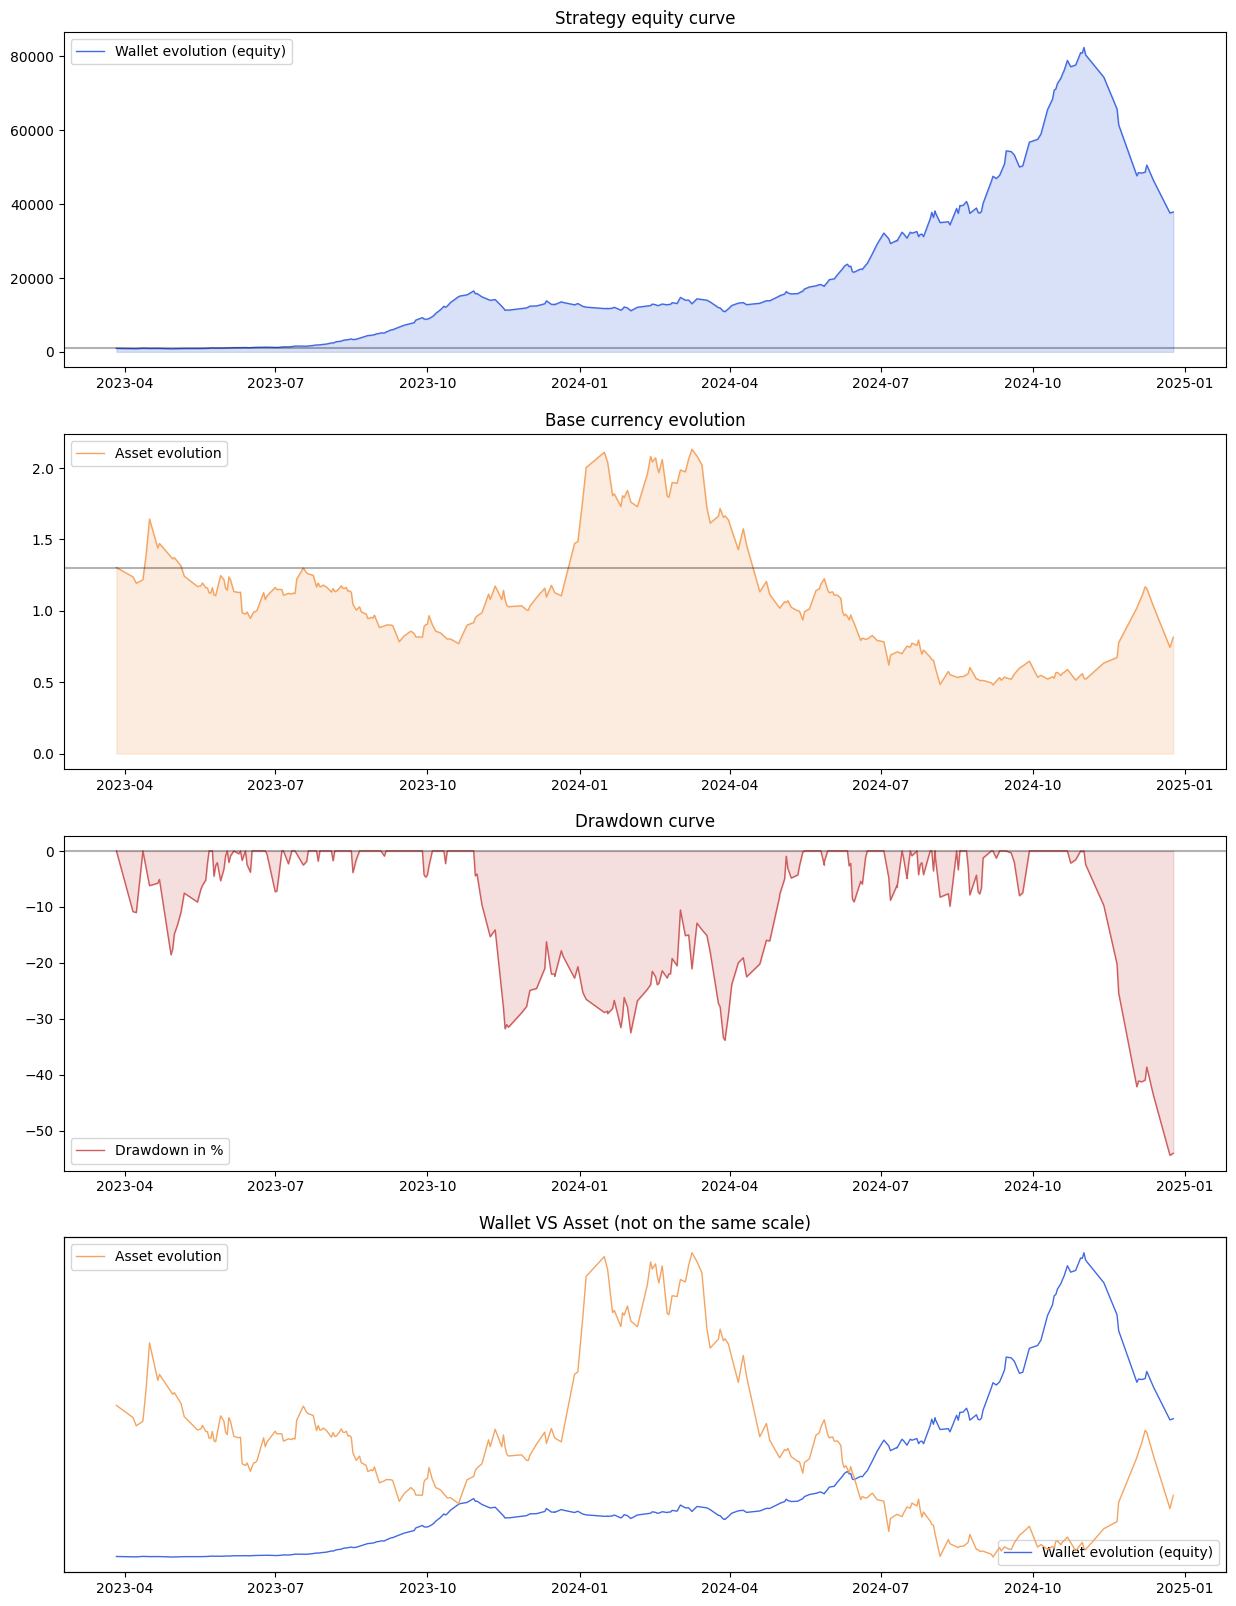

In [26]:
plot_wallet_vs_asset(df_days=df_days)

In [27]:
# plot_futur_simulations(
#     df_trades=df_trades,
#     trades_multiplier=1,
#     trades_to_forecast=1000,
#     number_of_simulations=100,
#     true_trades_to_show=10,
#     show_all_simulations=True,
# )

----- 2023 Cumulative Performances: 1290.54% -----


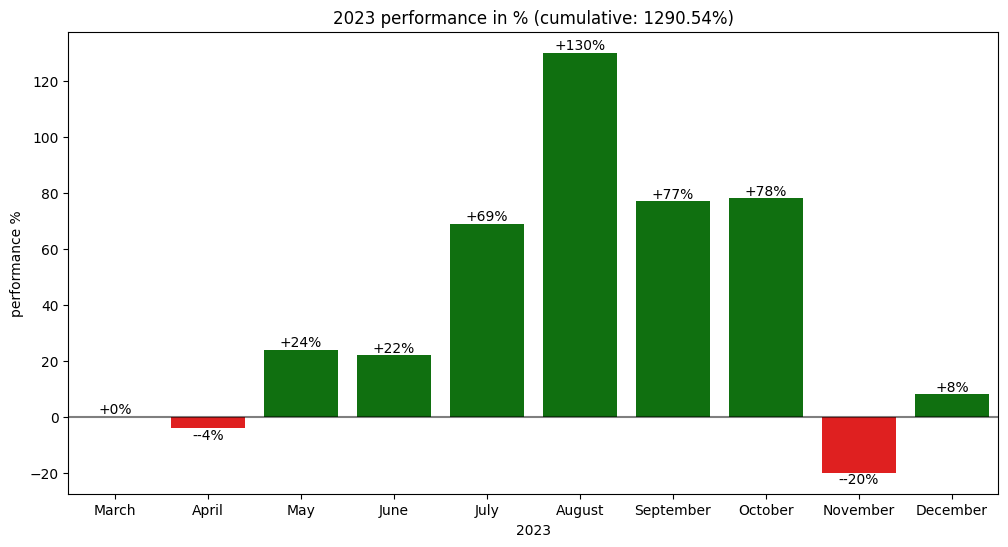

----- 2024 Cumulative Performances: 207.73% -----


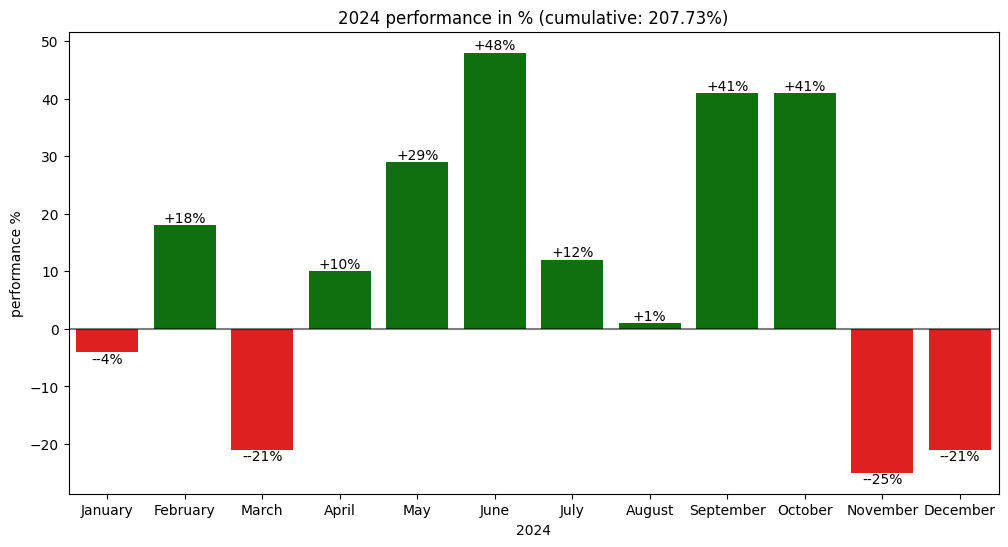

In [28]:
plot_bar_by_month(df_days=df_days)